In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from itertools import cycle
from scipy.integrate import solve_ivp

In [2]:
def Θ(x, x_rev, λ, θ):
    xk, xj = np.meshgrid(x, x)
    return (xj - x_rev)/(1 + np.exp(-λ*(xk - θ)))

In [3]:
def dΘ_dx(x, λ, θ):
    final = np.ones((x.size, x.size))/(1 + np.exp(-λ*(x - θ)))
    np.fill_diagonal(final, final.diagonal() + x*λ*np.exp(-λ*(x - θ))/(1+np.exp(-λ*(x - θ)))**2)
    return final

In [4]:
def hr_dots(current, _, b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2):
    x, y, z = map(lambda k: k.flatten(), np.split(current, 3))
    theta = Θ(x, x_rev, λ, θ)
    dots = np.zeros_like(current).reshape(3, -1)
    dots[0] = y - (x**3) + b*(x**2) + i0 - z - (α/n1)*np.sum(G1*theta, axis=1) - (β/n2)*np.sum(G2*theta, axis=1)
    dots[1] = 1 - 5*(x**2) - y
    dots[2] = μ*(s*(x - x_rest) - z)
    return np.hstack(dots)

In [5]:
def jac(_, y_in):
    x, y, z = map(lambda k: k.flatten(), np.split(y_in, 3))
    dtheta_dx = dΘ_dx(x, λ, θ)
    dẋ_dx = -3*x**2 + 2*b*x - (α/n1)*G1*dtheta_dx - (β/n2)*G2*dtheta_dx
    dẋ_dy = np.ones_like(dẋ_dx)
    dẋ_dz = -np.ones_like(dẋ_dy)

    dẏ_dx = -10*x*np.ones_like(dẋ_dz)
    dẏ_dy = -np.ones_like(dẏ_dx)
    dẏ_dz = np.zeros_like(dẏ_dy)

    dż_dx = μ*s*np.ones_like(dẏ_dz)
    dż_dy = np.zeros_like(dż_dx)
    dż_dz = -μ*np.ones_like(dż_dy)

    j_x = [dẋ_dx, dẋ_dy, dẋ_dz]
    j_y = [dẏ_dx, dẏ_dy, dẏ_dz]
    j_z = [dż_dx, dż_dy, dż_dz]

    return np.vstack([np.hstack(j_x), np.hstack(j_y), np.hstack(j_z)])

In [6]:
def cortex_size(mask, val):
    return int(np.sqrt(mask[mask == val].shape))

In [7]:
def plot_final_state(
    y,
    cortices=None, legend=False,
    title=None, channel=0,
    markers=["ro", "k^", "gX", "bD"],
    ylim=[-1.5, 2.5]
):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    for cortex in cortices:
        plt.plot(range(*cortex), y[-1, channel, cortex[0]:cortex[1]], next(m), label=f"{cortex[0]} - {cortex[1] - 1}")
    if legend:
        plt.legend(loc="best")
    if title:
        plt.title(title)
    plt.ylim(ylim)

In [8]:
def plot_beginning_and_end(y, start, end, p=0.99, legend=False, title=True, channel=0):
    l = y.shape[0]
    fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True)
    for i in range(start, end):
        ax1.plot(y[:int(p*l), channel, i], label=i)
        ax1.grid(True)
        ax1.set_xlim([0, int(p*l)])
        ax2.plot(y[int((1 - p)*l):, channel, i], label=i)
        ax2.grid(True)
        ax2.set_xlim([0, int(p*l)])
        plt.ylim([-1.5, 2.25])
    if legend:
        ax1.legend(loc="lower left")
    if title:
        plt.suptitle(f"First and last {100*p}\% of neurons {start} - {end}")

In [9]:
def plot_state_diagram(y, cortices=None, lim=[-1.5, 2.5], markers=["ro", "k^", "gX", "bD"]):
    if cortices is None:
        cortices = [[0, y.size]]
    m = iter(markers[:len(cortices)])
    ytp1 = y[:-1]
    yt = y[1:]
    for cortex in cortices:
        plt.plot(yt[cortex[0]:cortex[1]], ytp1[cortex[0]:cortex[1]], next(m))
    plt.xlim(lim)
    plt.ylim(lim)

In [10]:
def event(t, y, i):
    return y[i]
event.direction = 1.0

In [11]:
def time_to_index(t, tmax, N, as_int=True):
    out = (N*t/tmax)
    if as_int:
        return out.astype(int)
    else:
        return out

In [12]:
def firing_time_mask(firing_timeses, tmax, N):
    times = np.linspace(0, tmax, N)
    k_mask = np.zeros((N, len(firing_timeses)))
    t_mask = k_mask.copy()
    tp1_mask = t_mask.copy() + 1
    for i, firing_times in enumerate(firing_timeses):
        print(i)
        for j, firing_time in enumerate(firing_times[:-1]):
            k_mask[times >= firing_time, i] += 1
            t_mask[times >= firing_time, i] = firing_time
            tp1_mask[times >= firing_time, i] = firing_times[j + 1]
    return k_mask.astype(int), t_mask, tp1_mask

In [13]:
write = True

In [14]:
cortices = [[0, 18],
            [18, 28],
            [28, 46],
            [46, 65]]

In [15]:
n = np.loadtxt("../connectomes/cat_matrix.dat")/3
cortex_mask = np.zeros_like(n)
cortex_mask[:18, :18] = 1
cortex_mask[18:28, 18:28] = 2
cortex_mask[28:46, 28:46] = 3
cortex_mask[46:, 46:] = 4
G1 = n.copy()
G1[cortex_mask == 0] = 0
G2 = n.copy()
G2[cortex_mask != 0] = 0
events = [lambda t_in, y_in, i=i: event(t_in, y_in, i) for i in range(n.shape[0])]
for e in events:
    e.direction = 1.0

In [16]:
# For validation of the cortex sizes
for i in [1, 2, 3, 4]:
    print(i, cortex_size(cortex_mask, i))

1 18
2 10
3 18
4 19


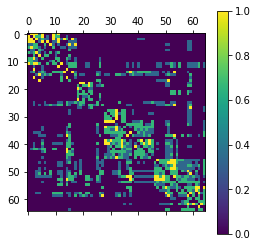

In [17]:
plt.matshow(n)
plt.colorbar()

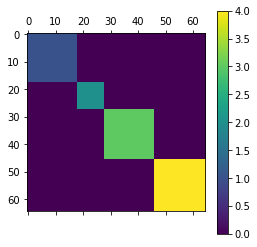

In [18]:
plt.matshow(cortex_mask)
plt.colorbar()

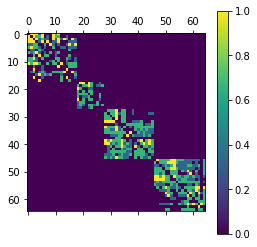

In [19]:
plt.matshow(G1)
plt.colorbar()

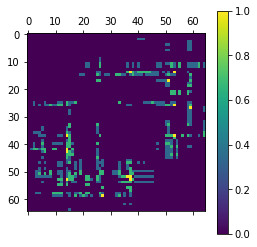

In [20]:
plt.matshow(G2)
plt.colorbar()

In [21]:
b = 3.2                           # Controls spiking frequency
i0 = 4.4*np.ones(n.shape[0])      # Input current ---- It's an array so we can add noise later
x_rev = 2                         # Reverse potential
λ = 10                            # Sigmoidal function parameter
θ = -0.25                         # Sigmoidal function parameter
μ = 0.01                          # Time scale of slow current
s = 4.0                           # Governs adaptation (whatever that means)
x_rest = -1.6                     # Resting potential ------ INCORRECT IN SANTOS PAPER
α = 0.210                         # Intra connection strength ---- VARIED PARAMETER
n1 = np.count_nonzero(G1, axis=1) # Number of intra connections from a given neuron
n1[n1 == 0] = 1                   # This is to remove a divide-by-zero; if n1 is 0, then so is G1
β = 0.040                         # Inter connection strength ---- VARIED PARAMETER
n2 = np.count_nonzero(G2, axis=1) # Number of inter connections from a given neuron
n2[n2 == 0] = 1                   # This is to remove a divide-by-zero; if n2 is 0, then so is G2

In [22]:
ivs = np.zeros([3, n.shape[0]])   # Initial values [[x], [y], [z]]
ivs[0] = 3.0*np.random.random(n.shape[0]) - 1.0
ivs[1] = 0.2*np.random.random(n.shape[0])
ivs[2] = 0.2*np.random.random(n.shape[0])

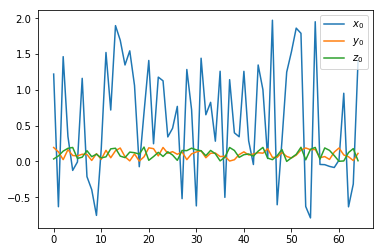

In [23]:
plt.plot(ivs[0], label=r"$x_{0}$")
plt.plot(ivs[1], label=r"$y_{0}$")
plt.plot(ivs[2], label=r"$z_{0}$")
plt.legend()

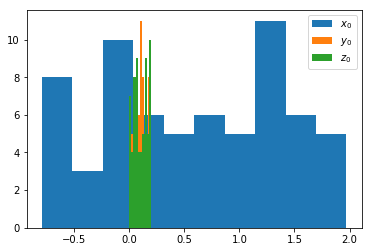

In [24]:
plt.hist(ivs[0], label=r"$x_{0}$")
plt.hist(ivs[1], label=r"$y_{0}$")
plt.hist(ivs[2], label=r"$z_{0}$")
plt.legend()

In [25]:
tmax = 4000
N = 100*tmax
t = np.linspace(0, tmax, N)

In [26]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [27]:
%%time
sol_sync = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                     t_span=(0, tmax), y0=ivs.reshape(ivs.size), events=events,
                     dense_output=True, method="RK45")

CPU times: user 1min 2s, sys: 112 ms, total: 1min 2s
Wall time: 1min 2s


In [28]:
vals_sync = sol_sync.sol(t).T
vals_sync = vals_sync.reshape(-1, 3, 65)
vals_sync.shape

(400000, 3, 65)

In [29]:
if write:
    with open("../../data/vals_sync.pkl", "wb") as f:
        pickle.dump(vals_sync, f)

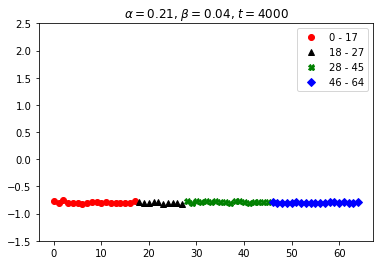

In [30]:
plot_final_state(y=vals_sync, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

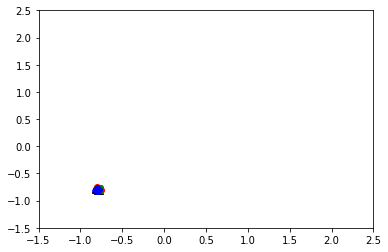

In [31]:
plot_state_diagram(vals_sync[-1, 0, :], cortices=cortices)

In [32]:
p = 0.03

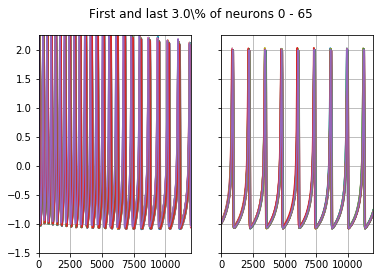

In [33]:
plot_beginning_and_end(vals_sync, 0, 65, p=p)

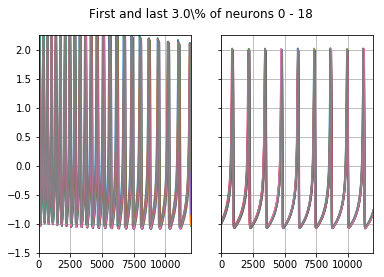

In [34]:
plot_beginning_and_end(vals_sync, 0, 18, p=p)

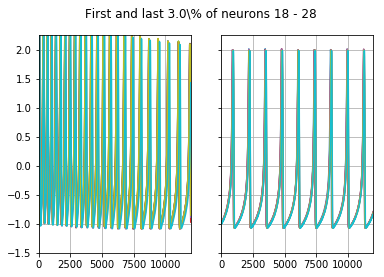

In [35]:
plot_beginning_and_end(vals_sync, 18, 28, p=p)

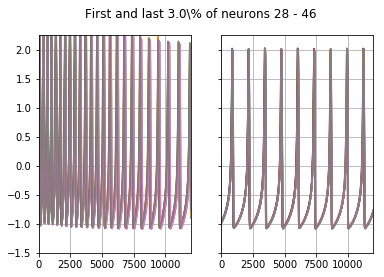

In [36]:
plot_beginning_and_end(vals_sync, 28, 46, p=p)

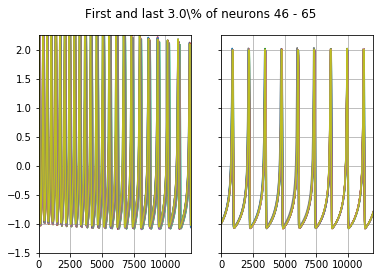

In [37]:
plot_beginning_and_end(vals_sync, 46, 65, p=p)

In [38]:
α = 0.001
β = 0.001

In [39]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [40]:
%%time
sol_async = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                      t_span=(0, tmax), y0=ivs.reshape(ivs.size), events=events,
                      dense_output=True, method="RK45")

/gpfs1/home/h/m/hmmitche/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 1min 34s, sys: 79.1 ms, total: 1min 34s
Wall time: 1min 34s


In [41]:
tmax/len(sol_async.t)

0.2020406101626427

In [42]:
vals_async = sol_async.sol(t).T
vals_async = vals_async.reshape(-1, 3, 65)
vals_async.shape

(400000, 3, 65)

In [43]:
if write:
    with open("../../data/vals_async.pkl", "wb") as f:
        pickle.dump(vals_async, f)

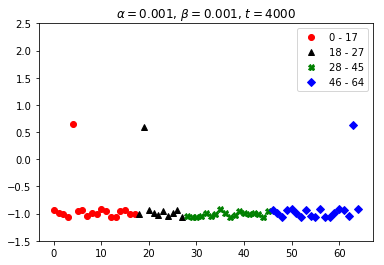

In [44]:
plot_final_state(y=vals_async, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

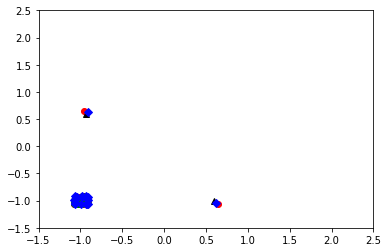

In [45]:
plot_state_diagram(vals_async[-1, 0, :], cortices=cortices)

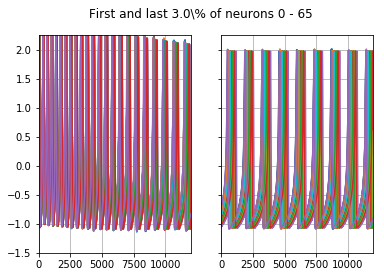

In [46]:
plot_beginning_and_end(vals_async, 0, 65, legend=False, p=p)

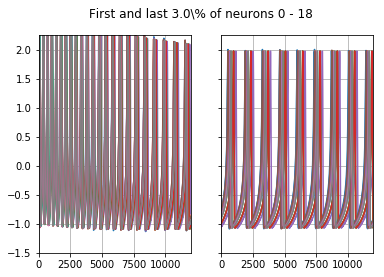

In [47]:
plot_beginning_and_end(vals_async, 0, 18, p=p)

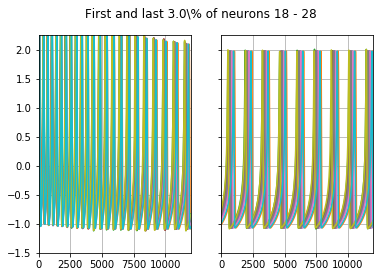

In [48]:
plot_beginning_and_end(vals_async, 18, 28, p=p)

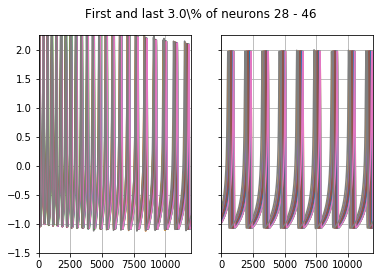

In [49]:
plot_beginning_and_end(vals_async, 28, 46, p=p)

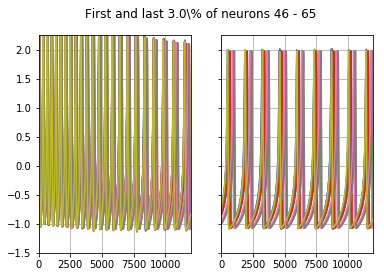

In [50]:
plot_beginning_and_end(vals_async, 46, 65, p=p)

In [51]:
α = 0.7
β = 0.08

In [52]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [53]:
%%time
sol_sc = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                   t_span=(0, tmax), y0=ivs.reshape(ivs.size), events=events,
                   dense_output=True, method="RK45")

/gpfs1/home/h/m/hmmitche/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 1min 7s, sys: 72.4 ms, total: 1min 8s
Wall time: 1min 8s


In [54]:
tmax/len(sol_sc.t)

0.2854899721647277

In [55]:
vals_sc = sol_sc.sol(t).T
vals_sc = vals_sc.reshape(-1, 3, 65)
vals_sc.shape

(400000, 3, 65)

In [56]:
if write:
    with open("../../data/vals_sc.pkl", "wb") as f:
        pickle.dump(vals_sc, f)

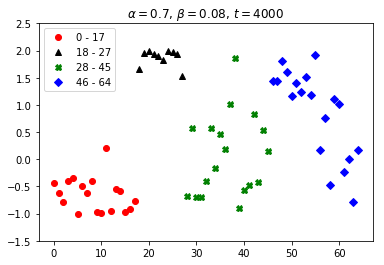

In [57]:
plot_final_state(y=vals_sc, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

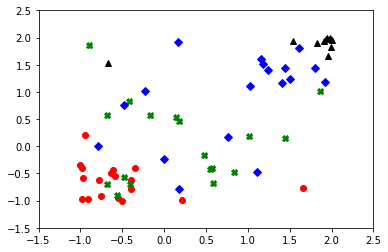

In [58]:
plot_state_diagram(vals_sc[-1, 0, :], cortices=cortices)

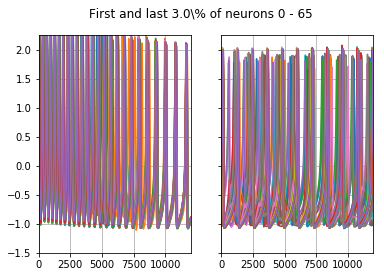

In [59]:
plot_beginning_and_end(vals_sc, 0, 65, legend=False, p=p)

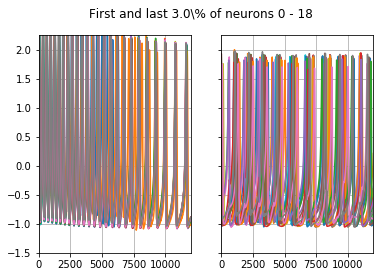

In [60]:
plot_beginning_and_end(vals_sc, 0, 18, p=p)

In [61]:
vals_sc.shape

(400000, 3, 65)

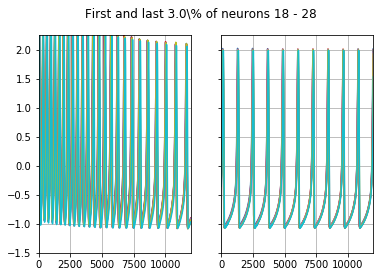

In [62]:
plot_beginning_and_end(vals_sc, 18, 28, p=p)

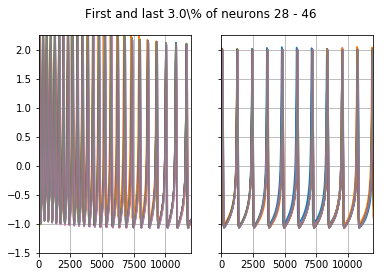

In [63]:
plot_beginning_and_end(vals_sc, 28, 46, p=p)

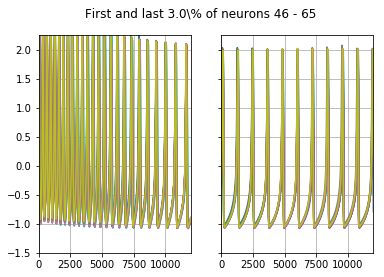

In [64]:
plot_beginning_and_end(vals_sc, 46, 65, p=p)

In [65]:
α = 1.5
β = 0.1

In [66]:
params = (b, i0, x_rev, λ, θ, μ, s, x_rest, α, n1, β, n2, G1, G2)

In [67]:
%%time
sol_bc = solve_ivp(fun=lambda t_in, y_in: hr_dots(y_in, t_in, *params),
                   t_span=(0, tmax), y0=ivs.reshape(ivs.size), events=events,
                   dense_output=True, method="RK45")

/gpfs1/home/h/m/hmmitche/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 1min 36s, sys: 11.4 ms, total: 1min 36s
Wall time: 1min 36s


In [68]:
tmax/len(sol_bc.t)

0.2054442732408834

In [69]:
vals_bc = sol_bc.sol(t).T
vals_bc = vals_bc.reshape(-1, 3, 65)
vals_bc.shape

(400000, 3, 65)

In [70]:
if write:
    with open("../../data/vals_bc.pkl", "wb") as f:
        pickle.dump(vals_bc, f)

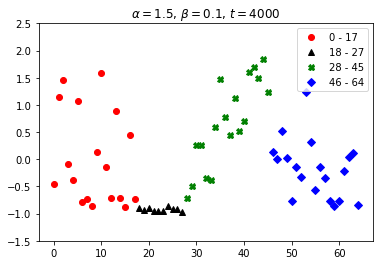

In [71]:
plot_final_state(y=vals_bc, cortices=cortices, legend=True, title=r"$\alpha = {}$, $\beta = {}$, $t = {}$".format(α, β, tmax))

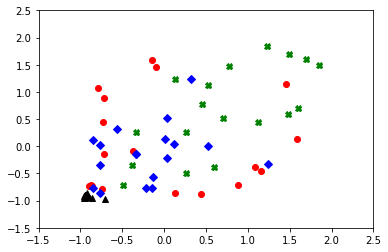

In [72]:
plot_state_diagram(vals_bc[-1, 0, :], cortices=cortices)

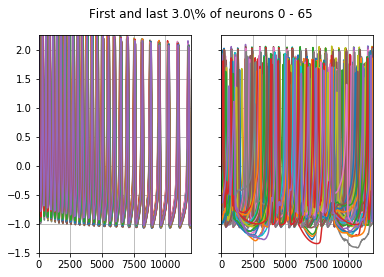

In [73]:
plot_beginning_and_end(vals_bc, 0, 65, legend=False, p=p)

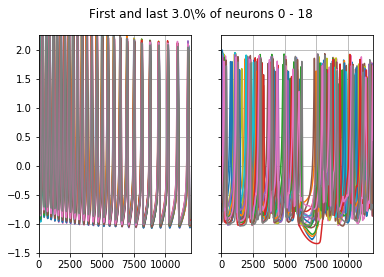

In [74]:
plot_beginning_and_end(vals_bc, 0, 18, p=p)

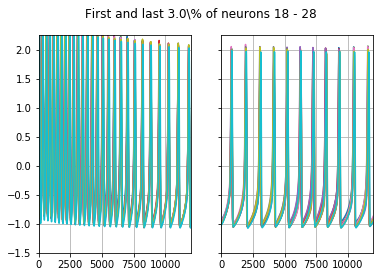

In [75]:
plot_beginning_and_end(vals_bc, 18, 28, p=p)

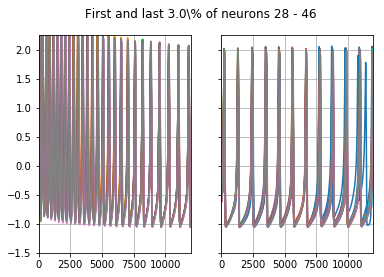

In [76]:
plot_beginning_and_end(vals_bc, 28, 46, p=p)

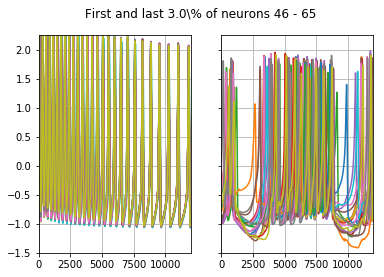

In [77]:
plot_beginning_and_end(vals_bc, 46, 65, p=p)

In [78]:
del(sol_sync, vals_sync, sol_async, vals_async, sol_sc, vals_sc)

In [79]:
t_events_bc = sol_bc.t_events

In [80]:
i_events_bc = time_to_index(t_events_bc[1], tmax, N)

In [81]:
vals_bc.shape

(400000, 3, 65)

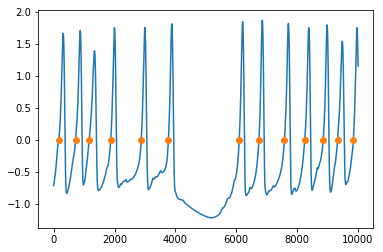

In [82]:
plt.plot(vals_bc[390000:, 0, 1])
plt.plot(i_events_bc[i_events_bc > 390000] - 390000, np.zeros_like(i_events_bc[i_events_bc > 390000]), "o")

In [83]:
t_bc = [sol_bc.t_events[i] for i in range(len(sol_bc.t_events))]

In [84]:
%%time
k_mask, t_mask, tp1_mask = firing_time_mask(t_bc, tmax, N)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
CPU times: user 7min 39s, sys: 1.13 s, total: 7min 40s
Wall time: 7min 40s


In [85]:
T = np.vstack(65*[t]).T

In [86]:
%%time
ϕ = 2*np.pi*(k_mask + (T - t_mask)/(tp1_mask - t_mask))

CPU times: user 355 ms, sys: 179 ms, total: 534 ms
Wall time: 534 ms


In [87]:
if write:
    with open("../../data/phase_bc.pkl", "wb") as f:
        pickle.dump(ϕ, f)

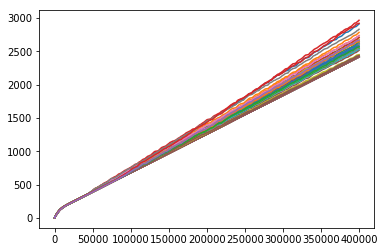

In [88]:
plt.plot(ϕ);

In [89]:
t_bc

[array([2.40712033e+00, 5.05031155e+00, 7.77374917e+00, 1.05523491e+01,
        1.34734094e+01, 1.64261191e+01, 1.95116629e+01, 2.26877427e+01,
        2.59820062e+01, 2.94817419e+01, 3.30428641e+01, 3.66826998e+01,
        4.06162224e+01, 4.46340181e+01, 4.89064923e+01, 5.34474939e+01,
        5.82848679e+01, 6.33107268e+01, 6.86647001e+01, 7.43455810e+01,
        8.04163107e+01, 8.69276288e+01, 9.38798181e+01, 1.01151220e+02,
        1.08947550e+02, 1.17203152e+02, 1.25868790e+02, 1.35005142e+02,
        1.44462268e+02, 1.54276727e+02, 1.64174172e+02, 1.74403601e+02,
        1.84827767e+02, 1.95003048e+02, 2.05109874e+02, 2.15971571e+02,
        2.27081823e+02, 2.38188247e+02, 2.49246302e+02, 2.59836026e+02,
        2.70370001e+02, 2.80953503e+02, 2.91588903e+02, 3.02810621e+02,
        3.13828030e+02, 3.24482850e+02, 3.34825944e+02, 3.45439380e+02,
        3.56808703e+02, 3.68503726e+02, 3.80052238e+02, 3.91315004e+02,
        4.02380449e+02, 4.13237460e+02, 4.23822234e+02, 4.340022

In [90]:
ϕ

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.28320102e-02, 6.28320102e-02, 6.28320102e-02, ...,
        6.28320102e-02, 6.28320102e-02, 6.28320102e-02],
       [1.25664020e-01, 1.25664020e-01, 1.25664020e-01, ...,
        1.25664020e-01, 1.25664020e-01, 1.25664020e-01],
       ...,
       [2.91203700e+03, 2.78529156e+03, 2.70941040e+03, ...,
        2.56985623e+03, 2.92177512e+03, 2.66468054e+03],
       [2.91204857e+03, 2.78530370e+03, 2.70942317e+03, ...,
        2.56986626e+03, 2.92178632e+03, 2.66468259e+03],
       [2.91206014e+03, 2.78531585e+03, 2.70943595e+03, ...,
        2.56987629e+03, 2.92179751e+03, 2.66468463e+03]])